In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import seaborn as sns
import math

In [4]:
base_df = pd.read_parquet("../tmp_data/clean_data/youbike_dock_info_history_2024-03-01_2024-03-18.parquet")

In [5]:
base_df.describe(include='all')

,id,name,lat,lng,space,full,empty,bike_yb2,bike_eyb,city,area,last_update_ts,extraction_ts
count,1.062835e+07,10628352,1.062835e+07,1.062835e+07,1.062835e+07,1.062835e+07,1.062835e+07,1.062835e+07,1.062835e+07,10628352,10628352,10628352,10628352
unique,NaN,6619,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,164,NaN,NaN
top,NaN,文林公園,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TaiBeiShi,BanQiaoQu,NaN,NaN
freq,NaN,4788,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2145115,294180,NaN,NaN
mean,5.006409e+08,NaN,2.418248e+01,1.209470e+02,2.122704e+01,7.447884e+00,1.341973e+01,7.101720e+00,3.461649e-01,NaN,NaN,2024-03-12 04:57:35.078238208+08:00,2024-03-12 09:00:23.084013312+08:00
min,5.001010e+08,NaN,2.190496e+01,1.201040e+02,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,NaN,2024-02-17 14:16:14+08:00,2024-03-01 04:18:31+08:00
25%,5.002070e+08,NaN,2.301972e+01,1.203920e+02,1.500000e+01,3.000000e+00,7.000000e+00,3.000000e+00,0.000000e+00,NaN,NaN,2024-03-10 11:42:18+08:00,2024-03-10 14:56:07+08:00
50%,5.006020e+08,NaN,2.443932e+01,1.208300e+02,1.800000e+01,6.000000e+00,1.100000e+01,5.000000e+00,0.000000e+00,NaN,NaN,2024-03-13 07:59:19+08:00,2024-03-13 11:14:44+08:00
75%,5.012031e+08,NaN,2.502900e+01,1.214920e+02,2.500000e+01,1.000000e+01,1.700000e+01,9.000000e+00,0.000000e+00,NaN,NaN,2024-03-16 01:06:18+08:00,2024-03-16 05:20:52+08:00
max,5.082010e+08,NaN,2.529301e+01,1.218665e+02,9.900000e+01,9.900000e+01,9.900000e+01,9.900000e+01,6.200000e+01,NaN,NaN,2024-03-18 23:49:18+08:00,2024-03-18 23:50:54+08:00


In [6]:
# Create target variable
base_df["pct_full"] = base_df["full"] / base_df["space"]

base_df["30m_fwd_pct_full"] = (base_df
                               .sort_values(by='extraction_ts')
                               .groupby('id')['pct_full']
                               .transform(lambda x: x.shift(-3))
                              ) # assumes each record is 10 mins apart - This is not correct !!


#Alternative target variable - seems more relevant 
base_df["30m_fwd_pct_full_rel_change"] = base_df["pct_full"] - base_df["30m_fwd_pct_full"]

# np.where( # Handles division of 0 over 0
#   (base_df["30m_fwd_pct_full"] / base_df["pct_full"]).isna(),
#     0,
#     base_df["30m_fwd_pct_full"] / base_df["pct_full"] - 1
# ) 

#  #This transformation needs review. It is far from ideal and will bias the model. Better would be to index all values between 0 and 1. 
# base_df['30m_fwd_pct_full_rel_change'] = np.where( 
#     (base_df["30m_fwd_pct_full"] / base_df["pct_full"]) == np.inf,
#     base_df["30m_fwd_pct_full"], 
#      base_df["30m_fwd_pct_full"] / base_df["pct_full"] - 1
# )

In [7]:
#Create feature df
feat_df = base_df.sort_values(by='extraction_ts').copy(deep=True)

In [8]:
#Add time features
feat_df['month'] = feat_df['extraction_ts'].dt.month
feat_df['day_of_week'] = feat_df['extraction_ts'].dt.weekday
feat_df['hour'] = feat_df['extraction_ts'].dt.hour

In [9]:
# Transform coordinate features - Idea is to try to group data in proximity
feat_df['lat'] = np.round(feat_df['lat'], 2)
feat_df['lng'] = np.round(feat_df['lng'], 2)

In [10]:
#Add Lag Features
## Apply rolling average 
feat_df["30m_blag_pct_full"] = (feat_df.sort_values(by='extraction_ts')
                               .groupby(by=['id'])['pct_full']
                               .transform(lambda x: x.shift(3)) #Assumes each record is 10 mins
                               ) 
    

feat_df["120m_avg_pct_full"] = (feat_df.sort_values(by='extraction_ts')
                               .groupby(by=['id'])['pct_full']
                               .transform(lambda x: x.rolling(window=12).mean()) #Assumes each record is 10 mins
                              ) 


# THe shift and rolling avg introduces some NaN values at the beginning of the timeseries. For now, they are just dropped. May need to review impact in the future
feat_df.dropna(subset=['30m_fwd_pct_full', '120m_avg_pct_full'], inplace=True)


In [11]:
#Format feat_df to schema
feat_df = feat_df[['id', 'city', 'lat',
       'lng', 'last_update_ts', 'extraction_ts', 'pct_full',
        'month', 'day_of_week', 'hour',
       '30m_blag_pct_full', '120m_avg_pct_full', '30m_fwd_pct_full','30m_fwd_pct_full_rel_change']].reset_index(drop=True)

### Analysis

In [53]:
rand_id = base_df['id'].sample(1, ignore_index=True)[0]

In [54]:
#Create df for specific station id
s_1 = ( base_df[base_df['id'] == rand_id]
       .sort_values(by="extraction_ts")
       .reset_index(drop=True)
       .copy(deep=True)
      )


# s_1["30m_avg_pct_full_X"] = s_1['pct_full'].rolling(window=3).mean() #Assumes each record is 10 mins

s_1.head(5)

,id,space,full,empty,city,lat,lng,last_update_ts,extraction_ts,pct_full,30m_fwd_pct_full,30m_fwd_pct_full_rel_change
0,500304039,10,4,5,TaoYuanShi,24.948864,121.260842,2024-02-29 21:36:18+08:00,2024-03-01 04:18:31+08:00,0.4,0.4,0.0
1,500304039,10,4,5,TaoYuanShi,24.948864,121.260842,2024-03-01 09:33:19+08:00,2024-03-01 11:00:48+08:00,0.4,0.4,0.0
2,500304039,10,4,5,TaoYuanShi,24.948864,121.260842,2024-03-01 09:33:19+08:00,2024-03-01 11:05:52+08:00,0.4,0.4,0.0
3,500304039,10,4,5,TaoYuanShi,24.948864,121.260842,2024-03-01 09:33:19+08:00,2024-03-01 11:10:57+08:00,0.4,0.4,0.0
4,500304039,10,4,5,TaoYuanShi,24.948864,121.260842,2024-03-01 09:33:19+08:00,2024-03-01 11:16:02+08:00,0.4,0.4,0.0


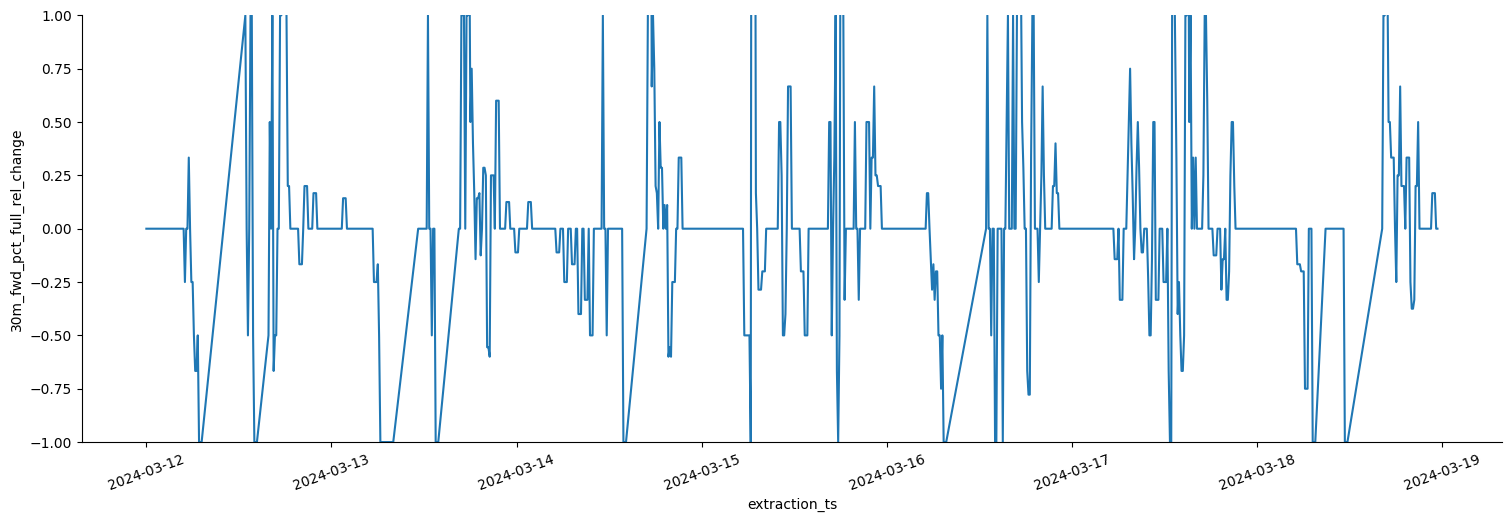

In [55]:
sns.relplot(kind="line", data=s_1.iloc[-1000:], x='extraction_ts', y='30m_fwd_pct_full_rel_change', aspect=3, height=5)
plt.xticks(rotation=20)
# Create a larger figure
plt.ylim(-1, 1)
plt.show()

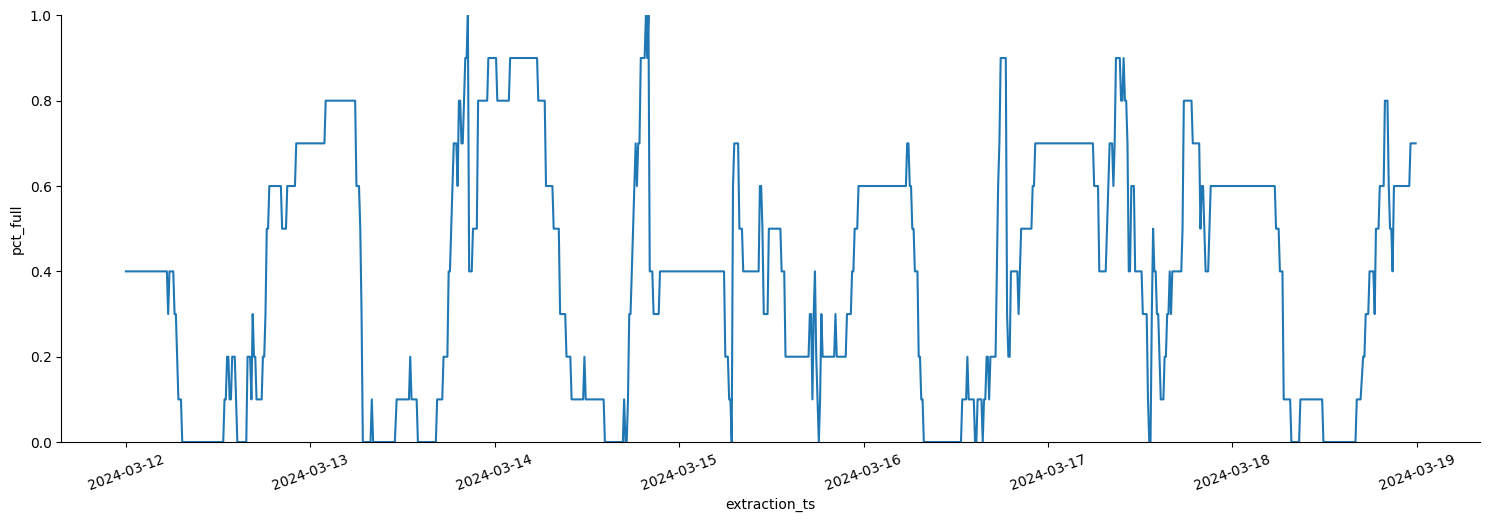

In [56]:
sns.relplot(kind="line", data=s_1.iloc[-1000:], x='extraction_ts', y='pct_full', aspect=3, height=5)
plt.xticks(rotation=20)
# Create a larger figure
plt.ylim(0, 1)
plt.show()

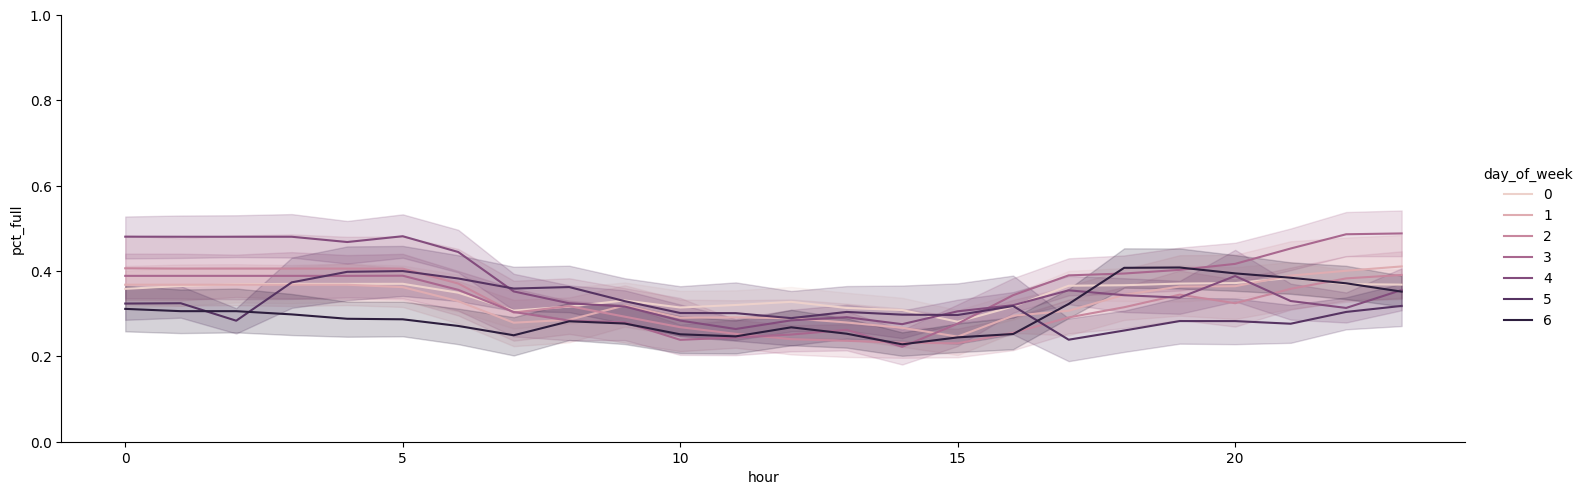

In [57]:
sns.relplot(kind="line", data=feat_df[feat_df['id'].isin(feat_df['id'].unique()[:10])] , x="hour", y="pct_full", hue="day_of_week", aspect=3)
plt.ylim(0, 1)
plt.show()

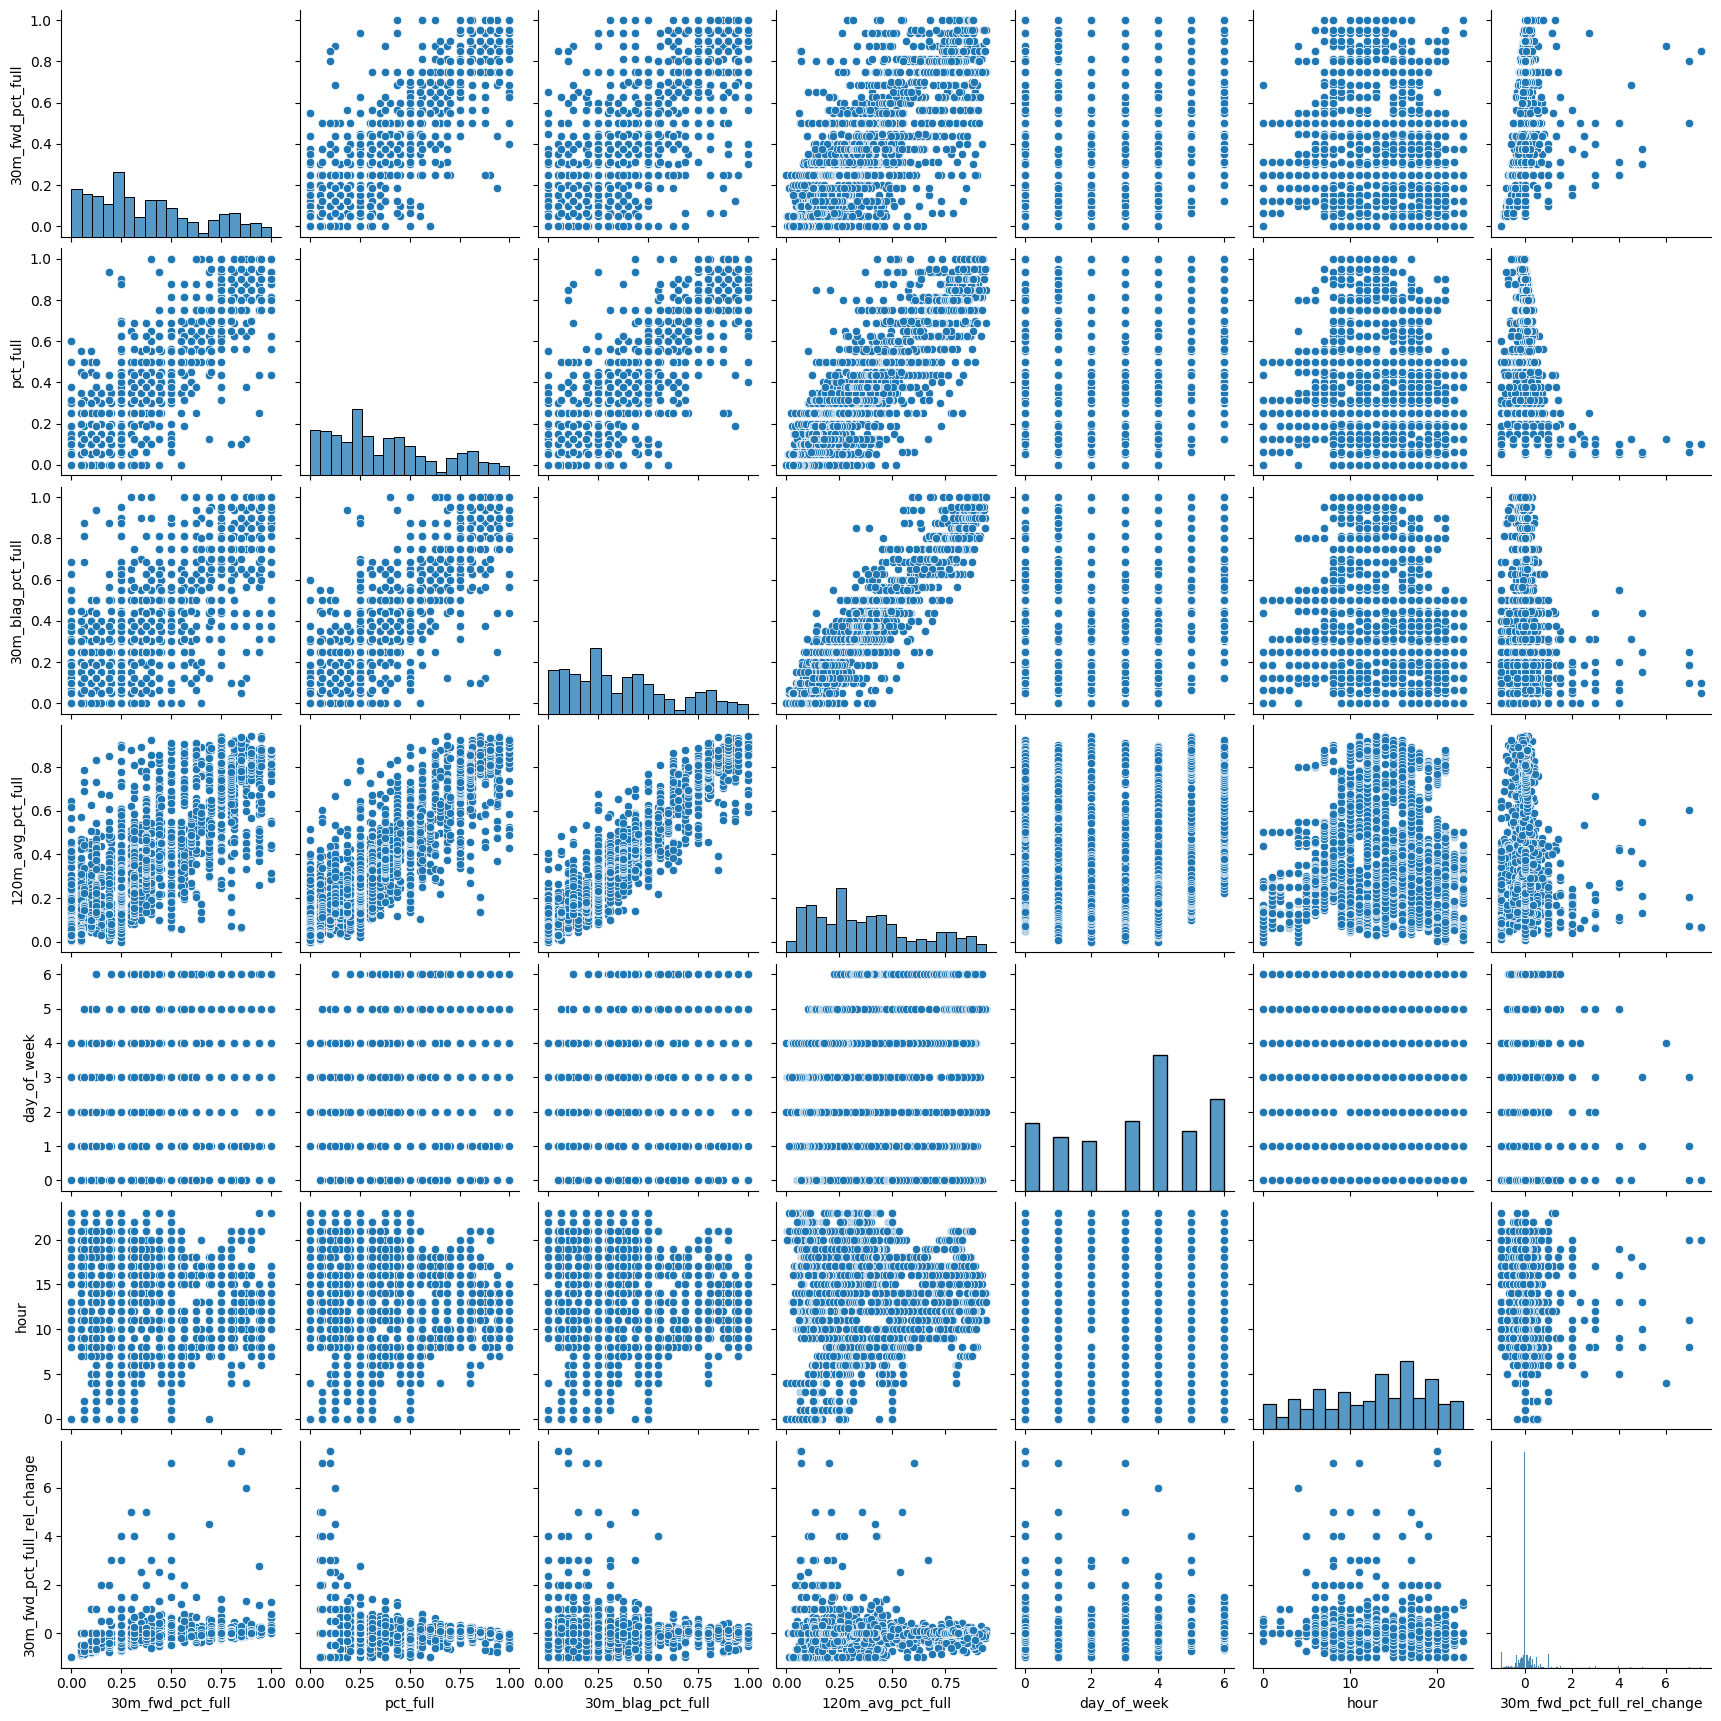

In [303]:
corr_vals = ['30m_fwd_pct_full','pct_full',
       '30m_blag_pct_full', "120m_avg_pct_full", 'day_of_week', 'hour', '30m_fwd_pct_full_rel_change']

s_2 = (    
      feat_df[
    # (feat_df['id'].isin(feat_df['id'].unique()[:1000])) 
    (feat_df['id'] == 500108116) | (feat_df['id'] == 500108117)
    # & (feat_df['city'] == 'TaiBeiShi')
    & (feat_df['hour'].isin(range(4,22, 1)))
    ]
       .sort_values(by="extraction_ts") 
       .reset_index(drop=True)
       .copy(deep=True)
      )

sns.pairplot(data=s_2, vars=corr_vals)


# Enrich Dataset with Weather

In [92]:
# Join weather data based on closest lat,lng and matching date and hour.  OK
# Create lag features of precipation in next time period etc. 

## Identify Weather Station ID based on station ID


Take the coord of each station, calculate magnitude with first weather coord. While magnitude is not smaller, keep same weather. 
<br>Store the state permanently for future joins. 

In [54]:
lat_list = [s[0] for s in WEATHER_STATIONS.values()]
lng_list = [s[1] for s in WEATHER_STATIONS.values()]

In [53]:
[s[1] for s in WEATHER_STATIONS.values()]

[121.54, 121.46, 121.28, 120.99, 120.7, 120.67, 120.44, 120.2, 120.32, 120.48]

In [12]:
WEATHER_STATIONS = {
        "TaiBei": [25.05, 121.54],
        "XinBei": [25.01, 121.46],
        "Taoyuan": [24.98, 121.28],
        "XinZhu": [24.81, 120.99],
        "MiaoLi": [24.57, 120.70],
        "TaiZhong": [24.14, 120.67],
        "JiaYi": [23.47, 120.44],
        "TaiNan": [22.99, 120.20],
        "GaoXiong": [22.63, 120.32],
        "PingDong": [22.67, 120.48],
    }
df_weather_stations = pd.DataFrame(list(WEATHER_STATIONS.items()), columns=['station_name', 'coords'])
df_weather_stations[['lat', 'lng']] = pd.DataFrame(df_weather_stations['coords'].tolist(), index=df_weather_stations.index)
df_weather_stations.drop('coords', axis=1, inplace=True)

In [15]:
# Approach: Run vectorized calculations
# Each column is one weather station, each row is one bike station. Then select column with lowest val for each row.
def np_magnitude(coord1: pd.DataFrame, coord2: pd.DataFrame):
    lat_vector = np.power(coord1['lat'] - coord2['lat'], 2)
    lng_vector =  np.power(coord1['lng'] - coord2['lng'], 2)  
    return np.sqrt(lat_vector + lng_vector)

#Need to rename to "get closest weather station or smth and add docstring that it requires lat and lng. could also build a weather station object for standard
def np_get_smallest_magnitude(coord: pd.DataFrame):
    #
    mag = coord.loc[:]
    for i, r in df_weather_stations.iterrows():
        mag[r['station_name']] = np_magnitude(coord, df_weather_stations[df_weather_stations['station_name'] == r['station_name']].iloc[0])
    return mag.drop(['lat','lng'], axis=1).idxmin(axis=1)

In [50]:
## This function is now super quick! No need to save state. But it would be a good use case still to have the weather station in a relational db, since it's a dimension
feat_df['weather_station'] = np_get_smallest_magnitude(feat_df[['lat', 'lng']])

## Join on Weather Station

In [18]:
# Import Weather Data
weather = pd.read_csv('/Users/justinwarambourg/Downloads/weather_data_raw_2024-03-19_09_57_50.csv')
weather['datetime'] = pd.to_datetime( weather['datetime'], yearfirst=True)

In [51]:
#To optimize by running this on the unique sets of timestamps 
feat_df['y_m_d_h'] = feat_df['extraction_ts'].dt.strftime('%Y-%m-%d_%H')
weather['y_m_d_h'] = weather['datetime'].dt.strftime('%Y-%m-%d_%H')

In [52]:
weather['weather_station'] = np_get_smallest_magnitude(weather[['lat', 'lng']])

In [53]:
merge_feat_df = pd.merge(
    left=feat_df,
    right=weather[['temperature', 'relative_humidity', 'apparent_temperature',
       'precipitation',  'wind_speed', 'y_m_d_h', 'weather_station']],
    on=['weather_station', 'y_m_d_h'],
    how='left'
    )

In [54]:
merge_feat_df = merge_feat_df[['id', 'city', 'lat', 'lng', 'last_update_ts',
       'extraction_ts', 'pct_full', '30m_fwd_pct_full', '30m_fwd_pct_full_rel_change', 'month', 'day_of_week',
       'hour', '30m_blag_pct_full', '120m_avg_pct_full', 
        'temperature', 'relative_humidity',
       'apparent_temperature', 'precipitation', 'wind_speed',
        ]]

## Add Weather features

In [55]:
feat_df = merge_feat_df.copy(deep=True)


In [24]:
feat_df.head(5)

,id,city,lat,lng,last_update_ts,extraction_ts,pct_full,30m_fwd_pct_full,30m_fwd_pct_full_rel_change,month,day_of_week,hour,30m_blag_pct_full,120m_avg_pct_full,temperature,relative_humidity,apparent_temperature,precipitation,wind_speed
0,501321059,TaiNanShi,22.99,120.24,2024-03-01 10:50:29+08:00,2024-03-01 12:02:43+08:00,0.272727,0.272727,0.000000,3,4,12,0.272727,0.272727,16.95,74.0,14.348667,0.0,22.725668
1,501316037,TaiNanShi,23.03,120.21,2024-02-29 10:14:14+08:00,2024-03-01 12:02:43+08:00,0.000000,0.000000,0.000000,3,4,12,0.000000,0.000000,16.95,74.0,14.348667,0.0,22.725668
2,500227003,XinBeiShi,24.98,121.55,2024-03-01 12:01:18+08:00,2024-03-01 12:02:43+08:00,0.245902,0.229508,-0.066667,3,4,12,0.229508,0.232240,12.95,88.0,10.421238,0.6,19.486609
3,500227002,XinBeiShi,24.99,121.53,2024-03-01 10:37:20+08:00,2024-03-01 12:02:43+08:00,0.800000,0.800000,0.000000,3,4,12,0.800000,0.772222,12.95,88.0,10.421238,0.6,19.486609
4,500227001,XinBeiShi,24.99,121.52,2024-03-01 08:01:14+08:00,2024-03-01 12:02:43+08:00,0.000000,0.000000,0.000000,3,4,12,0.000000,0.053571,12.85,86.0,10.212832,1.3,19.319628


In [56]:
#Temperature at time of next forecast
feat_df['30m_fwd_apparent_temperature'] = (feat_df
                                  .sort_values(by=['id','extraction_ts'])
                                  .groupby('id')['apparent_temperature']
                                  .transform(lambda x: x.shift(-3)) #Assumes each record is 10 mins (not true!) 
                                 )

feat_df['30m_fwd_precipitation'] = (feat_df
                                  .sort_values(by=['id','extraction_ts'])
                                  .groupby('id')['precipitation']
                                  .transform(lambda x: x.shift(-3)) #Assumes each record is 10 mins (not true!) 
                                 )

### Analysis

,id,city,last_update_ts,extraction_ts,pct_full,30m_fwd_pct_full,30m_fwd_pct_full_rel_change,month,day_of_week,hour,30m_blag_pct_full,120m_avg_pct_full,temperature,relative_humidity,apparent_temperature,precipitation,wind_speed,30m_fwd_apparent_temperature,30m_fwd_precipitation
0,500205049,XinBeiShi,2024-02-29 21:34:18+08:00,2024-03-01 04:18:31+08:00,0.208333,0.208333,0.000000,3,4,4,NaN,NaN,10.911500,86.294590,7.970955,0.2,17.848160,10.492206,2.9
1,500205050,XinBeiShi,2024-02-29 22:11:17+08:00,2024-03-01 04:18:31+08:00,0.545455,0.545455,0.000000,3,4,4,NaN,NaN,10.911500,86.294590,7.970955,0.2,17.848160,10.492206,2.9
2,500205051,XinBeiShi,2024-02-29 23:02:18+08:00,2024-03-01 04:18:31+08:00,0.576923,0.653846,0.133333,3,4,4,NaN,NaN,10.911500,86.294590,7.970955,0.2,17.848160,10.492206,2.9
3,500205052,XinBeiShi,2024-02-29 22:59:18+08:00,2024-03-01 04:18:31+08:00,0.347826,0.608696,0.750000,3,4,4,NaN,NaN,10.911500,86.294590,7.970955,0.2,17.848160,10.492206,2.9
4,500205049,XinBeiShi,2024-03-01 10:26:19+08:00,2024-03-01 11:00:48+08:00,0.208333,0.250000,0.200000,3,4,11,NaN,NaN,12.961499,81.183876,10.492206,2.9,16.676977,10.492206,2.9


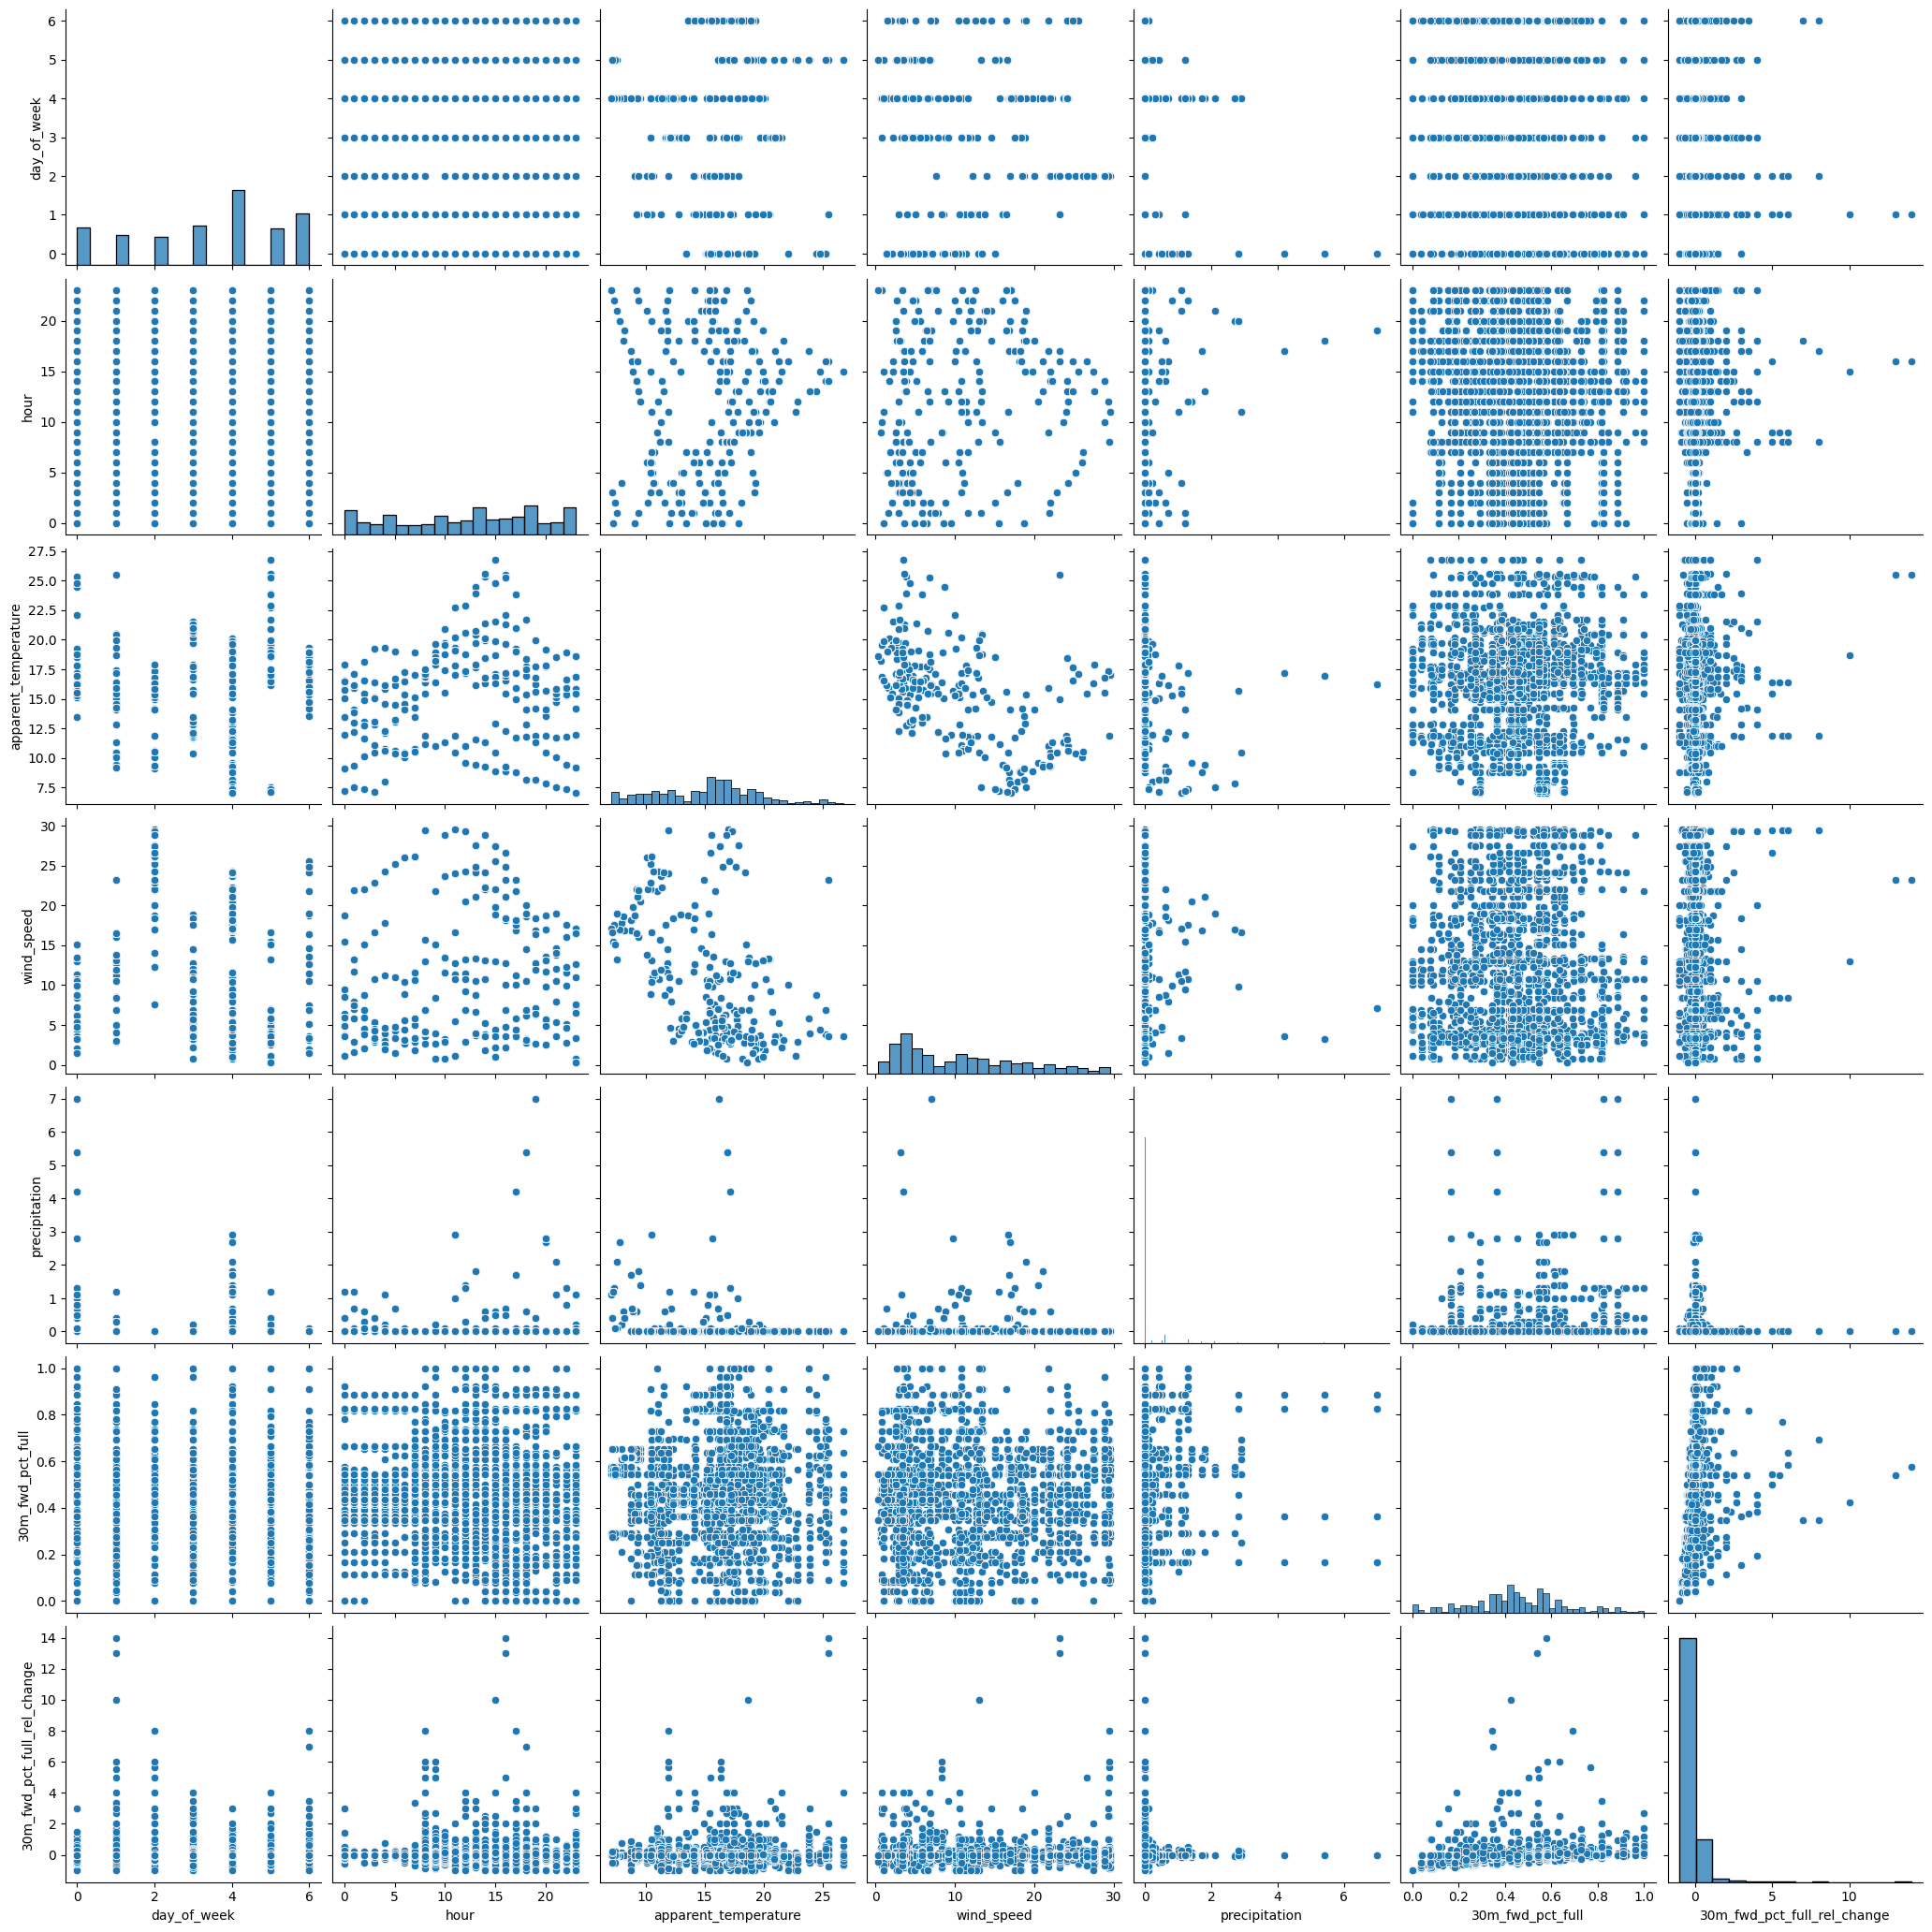

In [398]:
corr_vals = [
        'day_of_week', 'hour', 'apparent_temperature', 'wind_speed', 'precipitation', '30m_fwd_pct_full', '30m_fwd_pct_full_rel_change']

s_3 = (    
      feat_df[
    # (feat_df['id'].isin(feat_df['id'].unique()[:1000])) 
    (feat_df['id'] == 500205050) 
    | (feat_df['id'] == 500205051)
    | (feat_df['id'] == 500205052)
    | (feat_df['id'] == 500205049)
    # & (feat_df['city'] == 'TaiBeiShi')
    # & (feat_df['hour'].isin(range(4,22, 1)))
    ]
       .sort_values(by="extraction_ts") 
       .reset_index(drop=True)
       .copy(deep=True)
      )

display(sns.pairplot(data=s_3, vars=corr_vals, aspect=1, height=3))
display(s_3.head(5))


<Axes: xlabel='30m_fwd_pct_full_rel_change', ylabel='Density'>

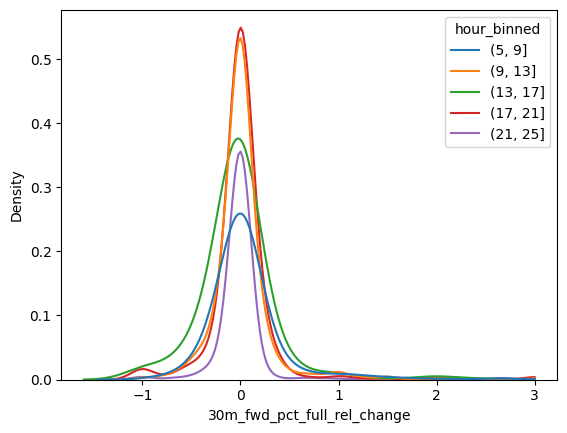

In [400]:

bins = range(10, 26, 5)

# temp_binned = 
s_3['temp_binned'] = pd.cut(s_3['apparent_temperature'], bins)
s_3['30m_fwd_precipitation_binned'] = pd.cut(s_3['30m_fwd_precipitation'], np.linspace(0, 2, 5))
s_3['precipitation_binned'] = pd.cut(s_3['precipitation'], range(2,6,1))
s_3['hour_binned'] = pd.cut(s_3['hour'], range(5, 26, 4))
sns.kdeplot(data=s_3, x='30m_fwd_pct_full_rel_change', hue='hour_binned', clip=[-3,3],  )
# catplot(kind='violin', data=s_3, x='temp_binned', y='30m_fwd_pct_full_rel_change')

<Axes: xlabel='30m_fwd_pct_full_rel_change', ylabel='Density'>

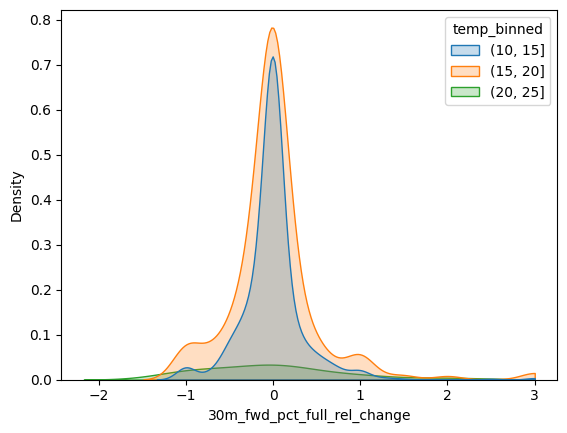

In [393]:
sns.kdeplot(data=s_3, x='30m_fwd_pct_full_rel_change', hue='temp_binned', clip=[-3,3], fill=True )

# Wrap Up

In [57]:
# Remove feature-selection specific columns
feat_df = feat_df.drop(['last_update_ts', '30m_fwd_pct_full', 'temperature', 'relative_humidity'], axis=1).reset_index(drop=True)
#Save Merged Youbike & Weather df
feat_df.to_parquet('./model_features_2024-03-18.parquet' , index=False)